In [73]:
%config InlineBackend.figure_formats = ["svg"]

# Week 7: Health and Disease

In [ ]:
!pip install -q geopandas networkx us census 

In [2]:
import json

import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import us

from census import Census
from shapely.geometry import Point

## Mortality (via CDC WONDER)

### The opioid epidemic and drug overdose deaths

In [69]:
causes_of_death_df = pd.read_csv("data/Underlying Cause of Death, 1999-2020.txt", sep="\t").drop(
    columns=["Notes", "Year Code", "Crude Rate", "Hispanic Origin Code", "Race Code"]
).rename(columns={
    "State": "state",
    "State Code": "state_fips",
    "Year": "year",
    "Hispanic Origin": "hispanic_origin",
    "Race": "race",
    "Drug/Alcohol Induced Cause": "cause",
    "Drug/Alcohol Induced Cause Code": "cause_code",
    "Deaths": "deaths",
    "Population": "state_pop",
})

In [70]:
causes_of_death_df

,state,state_fips,year,hispanic_origin,race,cause,cause_code,deaths,state_pop
0,Alabama,1,1999,Hispanic or Latino,White,All other non-drug and non-alcohol causes,O9,81,58333
1,Alabama,1,1999,Not Hispanic or Latino,American Indian or Alaska Native,All other non-drug and non-alcohol causes,O9,52,22132
2,Alabama,1,1999,Not Hispanic or Latino,Asian or Pacific Islander,All other non-drug and non-alcohol causes,O9,44,32953
3,Alabama,1,1999,Not Hispanic or Latino,Black or African American,Drug poisonings (overdose) Unintentional (X40-...,D1,27,1156898
4,Alabama,1,1999,Not Hispanic or Latino,Black or African American,All other alcohol-induced causes,A9,89,1156898
...,...,...,...,...,...,...,...,...,...
18391,Wyoming,56,2020,Not Hispanic or Latino,White,Drug poisonings (overdose) Unintentional (X40-...,D1,69,493371
18392,Wyoming,56,2020,Not Hispanic or Latino,White,Drug poisonings (overdose) Suicide (X60-X64),D2,10,493371
18393,Wyoming,56,2020,Not Hispanic or Latino,White,All other alcohol-induced causes,A9,161,493371
18394,Wyoming,56,2020,Not Hispanic or Latino,White,All other non-drug and non-alcohol causes,O9,5117,493371


In [71]:
causes_of_death_df["race"].unique()

array(['White', 'American Indian or Alaska Native',
       'Asian or Pacific Islander', 'Black or African American'],
      dtype=object)

In [72]:
causes_of_death_df["hispanic_origin"].unique()

array(['Hispanic or Latino', 'Not Hispanic or Latino', 'Not Stated'],
      dtype=object)

In [29]:
causes_of_death_df[["cause", "cause_code"]].drop_duplicates().sort_values(by=["cause_code"])

,cause,cause_code
52,"Alcohol poisonings (overdose) (X45, X65, Y15)",A1
4,All other alcohol-induced causes,A9
0,Drug poisonings (overdose) Unintentional (X40-...,D1
1,Drug poisonings (overdose) Suicide (X60-X64),D2
573,Drug poisonings (overdose) Homicide (X85),D3
2,Drug poisonings (overdose) Undetermined (Y10-Y14),D4
3,All other drug-induced causes,D9
5,All other non-drug and non-alcohol causes,O9


#### National trends

In [37]:
state_pops_by_year_df = causes_of_death_df[["year", "state", "state_pop"]].drop_duplicates()
state_pops_by_year_df

,year,state,state_pop
0,1999,Alabama,4430141
6,2000,Alabama,4447100
12,2001,Alabama,4467634
18,2002,Alabama,4480089
24,2003,Alabama,4503491
...,...,...,...
6895,2016,Wyoming,585501
6900,2017,Wyoming,579315
6905,2018,Wyoming,577737
6909,2019,Wyoming,578759


In [42]:
pop_by_year = state_pops_by_year_df.groupby(by=["year"]).sum()["state_pop"]
pop_by_year

year
1999    279040168
2000    281421906
2001    284968955
2002    287625193
2003    290107933
2004    292805298
2005    295516599
2006    298379912
2007    301231207
2008    304093966
2009    306771529
2010    308745538
2011    311591917
2012    313914040
2013    316128839
2014    318857056
2015    321418820
2016    323127513
2017    325719178
2018    327167434
2019    328239523
2020    329484123
Name: state_pop, dtype: int64

In [40]:
death_counts = causes_of_death_df.groupby(by=["year"]).sum()["deaths"]
death_counts

year
1999    2391035
2000    2402987
2001    2416084
2002    2443022
2003    2447988
2004    2397320
2005    2447703
2006    2425935
2007    2423447
2008    2471771
2009    2436937
2010    2468187
2011    2515199
2012    2543054
2013    2596801
2014    2626196
2015    2712432
2016    2744040
2017    2813304
2018    2838933
2019    2854580
2020    3383537
Name: deaths, dtype: int64

In [49]:
unintentional_overdose_death_counts = causes_of_death_df[
    causes_of_death_df["cause_code"] == "D1"
].groupby(by=["year"]).sum()["deaths"]

unintentional_overdose_death_counts

year
1999    11135
2000    11700
2001    13013
2002    16380
2003    18286
2004    19836
2005    22441
2006    26392
2007    27658
2008    28171
2009    28754
2010    30006
2011    33071
2012    33175
2013    35663
2014    38718
2015    44126
2016    54793
2017    61311
2018    58908
2019    62172
2020    83558
Name: deaths, dtype: int64

fig, ax = plt.subplots(figsize=(16, 8))
(100 * (unintentional_overdose_death_counts / death_counts)).plot.line(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("% of deaths")
ax.set_title("% of U.S. deaths from unintentional drug overdoses")
plt.show()

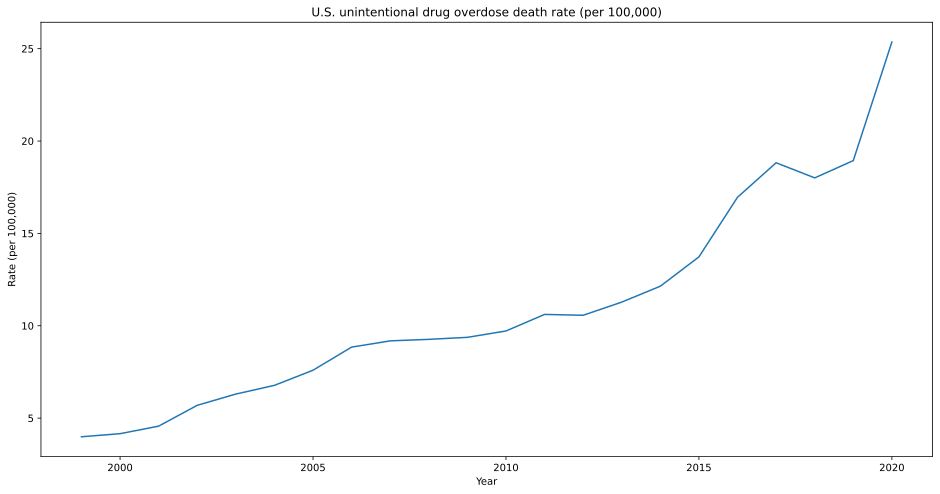

In [75]:
# This plot is not age-adjusted. How would you fix this?
# https://www.cdc.gov/nchs/hus/sources-definitions/age-adjustment.htm

fig, ax = plt.subplots(figsize=(16, 8))
(100000 * (unintentional_overdose_death_counts / pop_by_year)).plot.line(ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Rate (per 100,000)")
ax.set_title("U.S. unintentional drug overdose death rate (per 100,000)")
plt.show()

### Cancer hotspots